In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import h5py
from tqdm import tqdm
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten

# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs): #assuming latent_dim=16, n_embd=128, the input will be (,7,7,16), output is still (,7,7,16)
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        ) # latent * n_embd float 32 ~ 5k pamaters 2D

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim]) # (batch * 7 * 7, 16)

        # Quantization.
        encoding_indices = self.get_code_indices(flattened) # for each input image, 49 element output from conv2D, each one corresponding to one of the 128 embeded vector
        encodings = tf.one_hot(encoding_indices, self.num_embeddings) # (flat,128) ont hot
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True) # (flat,128)*((16,128).T) = (flat,16), each element corresponding to one embded vector
        quantized = tf.reshape(quantized, input_shape) #reshaping thr flat to batch * 7 * 7, each position corresponding to one embded vector

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings) #product the (batch * 7 * 7, 16) and (16,128), that is (batch * 7 * 7, 128);;let flat=batch * 7 * 7
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True) 
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        ) #(flat,1)+(128)-(flat,128) ?

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1) #return the id of one of the embeddings, then it is a (flat) 1D array contianting 0~128
        
#         print(flattened_inputs.shape) #flat,16
#         print(tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True).shape) #(flat,1)
#         print(self.embeddings.shape) #(16,128)
#         print(tf.reduce_sum(self.embeddings ** 2, axis=0).shape) # (128)
#         print(similarity.shape) #(flat,128)
#         print(distances.shape) #(flat,128)
#         print(encoding_indices.shape)#(flat)
        return encoding_indices #quantized to a number, like 0~128


In [8]:
input_shape = 57
latent_dimension = 3
num_nodes=[32,16]

In [43]:
def get_encoder(latent_dim=3,input_shape = 57, num_nodes=[32,16]):
    inputArray = Input(shape=(input_shape))
    x = BatchNormalization()(inputArray)
    x = Dense(num_nodes[0], use_bias=False)(x)
    x = Activation(tf.nn.leaky_relu)(x)
    x = Dense(num_nodes[1], use_bias=False)(x)
    x = Activation(tf.nn.leaky_relu)(x)
    x = Dense(latent_dimension, use_bias=False)(x)
    encoder = Activation(tf.nn.leaky_relu)(x)
    return Model(inputs=inputArray, outputs=encoder)


def get_decoder(latent_dim=3,input_shape = 57, num_nodes=[32,16]):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = Dense(num_nodes[0], use_bias=False)(latent_inputs)
    x = Activation(tf.nn.leaky_relu)(x)
    decoder = Dense(input_shape)(x)

    return Model(inputs=latent_inputs, outputs= decoder)


In [44]:
get_encoder(16).output.shape[1:]

TensorShape([3])

In [45]:
get_encoder(16).summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 57)]              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 57)                228       
_________________________________________________________________
dense_73 (Dense)             (None, 32)                1824      
_________________________________________________________________
activation_66 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 16)                512       
_________________________________________________________________
activation_67 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 3)               

In [46]:
get_decoder(32).summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                96        
_________________________________________________________________
activation_72 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 57)                1881      
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


In [47]:
def get_vqvae(latent_dim=3, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=57
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

SyntaxError: invalid syntax (<ipython-input-47-7eafbed9add4>, line 6)

In [48]:
get_vqvae(1,128).summary()

Model: "vq_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 57)]              0         
_________________________________________________________________
functional_59 (Functional)   (None, 3)                 2612      
_________________________________________________________________
vector_quantizer (VectorQuan (None, 3)                 128       
_________________________________________________________________
functional_63 (Functional)   (None, 57)                1977      
Total params: 4,717
Trainable params: 4,603
Non-trainable params: 114
_________________________________________________________________


In [49]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def call(self,x): #bug, the keras required the call here. 2.7 will fix this.
        self.train_step(x)
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [50]:
filename = 'BKG_dataset.h5'

In [51]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [52]:
X_train.shape

(640000, 57)

In [53]:
X_test.shape

(200000, 57)

In [54]:
X_train.shape

(640000, 57)

In [55]:
training_data = np.concatenate((X_train,X_val))

In [56]:
data_variance = np.var(training_data)

In [57]:
data_variance

83.38244512834959

In [59]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=3, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(training_data, epochs=100, batch_size=128)
# vqvae_trainer.save_weights("trainer_mini.wt")
#load weights to avoid the retraining
# vqvae_trainer.load_weights("trainer.wt")

Epoch 1/100
6250/6250 [==============================] - 13s 2ms/step - loss: 1.8265 - reconstruction_loss: 0.2987 - vqvae_loss: 1.3397
Epoch 2/100
6250/6250 [==============================] - 14s 2ms/step - loss: 0.4302 - reconstruction_loss: 0.1065 - vqvae_loss: 0.3158
Epoch 3/100
6250/6250 [==============================] - 15s 2ms/step - loss: 0.3946 - reconstruction_loss: 0.0852 - vqvae_loss: 0.3048
Epoch 4/100
6250/6250 [==============================] - 15s 2ms/step - loss: 0.3709 - reconstruction_loss: 0.0720 - vqvae_loss: 0.2959
Epoch 5/100
6250/6250 [==============================] - 13s 2ms/step - loss: 0.2925 - reconstruction_loss: 0.0677 - vqvae_loss: 0.2247
Epoch 6/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.3381 - reconstruction_loss: 0.0649 - vqvae_loss: 0.2699
Epoch 7/100
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2460 - reconstruction_loss: 0.0631 - vqvae_loss: 0.1846
Epoch 8/100
6250/6250 [=========================

6250/6250 [==============================] - 16s 3ms/step - loss: 0.1707 - reconstruction_loss: 0.0496 - vqvae_loss: 0.1207
Epoch 61/100
6250/6250 [==============================] - 19s 3ms/step - loss: 0.1618 - reconstruction_loss: 0.0497 - vqvae_loss: 0.1121
Epoch 62/100
6250/6250 [==============================] - 18s 3ms/step - loss: 0.1662 - reconstruction_loss: 0.0492 - vqvae_loss: 0.1166
Epoch 63/100
6250/6250 [==============================] - 17s 3ms/step - loss: 0.1641 - reconstruction_loss: 0.0493 - vqvae_loss: 0.1144
Epoch 64/100
6250/6250 [==============================] - 15s 2ms/step - loss: 0.1646 - reconstruction_loss: 0.0492 - vqvae_loss: 0.1156
Epoch 65/100
6250/6250 [==============================] - 15s 2ms/step - loss: 0.1636 - reconstruction_loss: 0.0490 - vqvae_loss: 0.1151
Epoch 66/100
6250/6250 [==============================] - 16s 3ms/step - loss: 0.1645 - reconstruction_loss: 0.0493 - vqvae_loss: 0.1159
Epoch 67/100
6250/6250 [==============================

In [82]:
trained_vqvae_model = vqvae_trainer.vqvae


In [83]:
bkg_prediction = trained_vqvae_model.predict(X_test)

In [84]:
bkg_prediction.shape

(200000, 57)

In [85]:
X_test.shape

(200000, 57)

In [86]:
signal_labels = ['Particles', 'Particles','Particles','Particles']

In [87]:
signals_file = ['Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

In [88]:
# add correct path to signal files
signal_data = []
for i, label in enumerate(signal_labels, ):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
        test_data = test_data[:,:,0:3]
    signal_data.append(test_data)

In [90]:
signal_data[0].shape

(55969, 19, 3)

In [91]:
signal_results = []

for i, label in tqdm(enumerate(signal_labels)):
    signal_prediction = trained_vqvae_model.predict(signal_data[i].reshape(-1,57))

    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal
    

4it [00:48, 12.11s/it]


In [92]:
from func import mse_loss

In [93]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test.reshape(-1,57), bkg_prediction.astype(np.float32).reshape(-1,57)).numpy())
for i, signal_X in enumerate(signal_data):
    sig_results = np.reshape(signal_results[i][2].astype(np.float32), (-1,57))
    sigX = np.reshape(signal_X,(-1,57))
    total_loss.append(mse_loss(sigX,sig_results).numpy())

In [94]:
from sklearn.metrics import roc_curve, auc
labels = np.concatenate([['Background'], np.array(signal_labels)])
signals_files = ['Background','Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

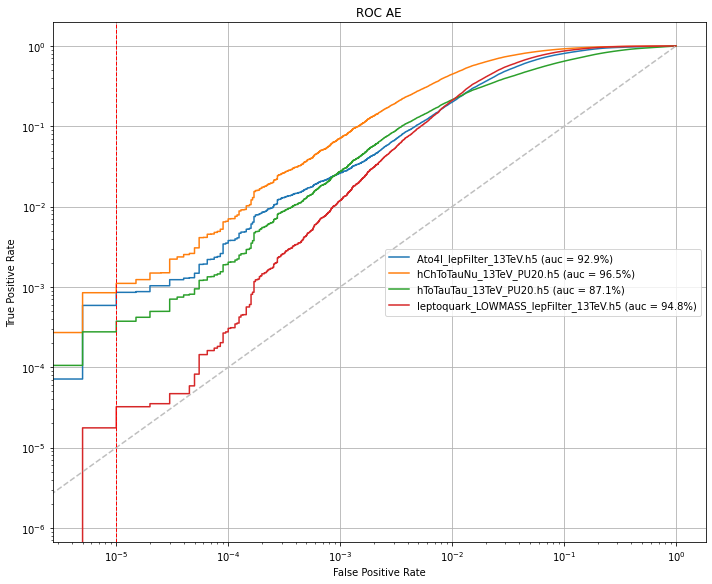

In [95]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(signals_files[i],auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

In [197]:
kl = tf.keras.losses.KLDivergence()


In [228]:
# compute loss value (true, predicted)
total_loss = [[],[],[],[]]
for x in range(X_test.shape[0]):
    total_loss[0].append(kl(X_test[x], bkg_prediction.astype(np.float32)[x]).numpy())
for i, signal_X in enumerate(signal_data):

    total_loss.append(kl(signal_X, signal_results[i][2].astype(np.float32)).numpy())

KeyboardInterrupt: 

In [225]:
total_loss[1]

0.72223955

[1. 0.]
[0.72223955 0.21897088]
[1. 0.]
[0.64292854 0.21897088]
[1. 0.]
[0.5052309  0.21897088]
[1. 0.]
[0.5053181  0.21897088]


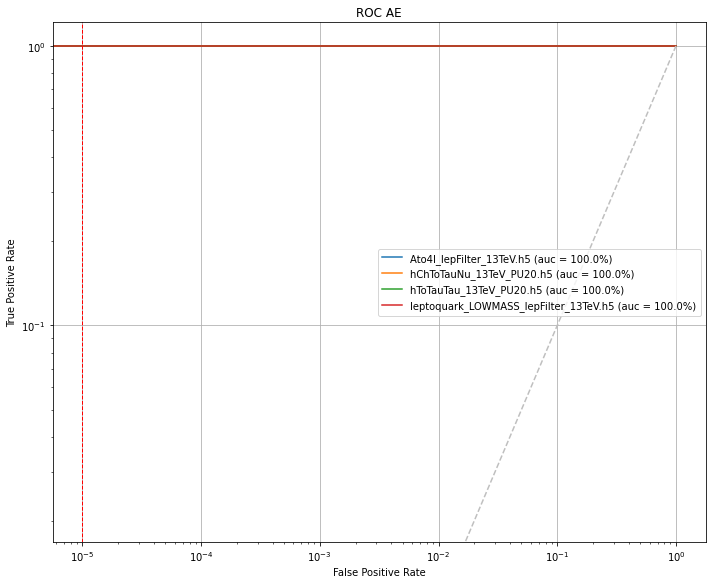

In [226]:

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.array((np.ones(total_loss[i].shape), 0)) # anomaly=1, bkg=0
    predVal_loss = np.array([total_loss[i],total_loss[0]])
    print(trueVal)
    print(predVal_loss)
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(signals_files[i],auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()